# How to use the normal approximations module

This module explains how to approximate existing priors and posteriors with normal distributions and how to propagate errors.
It compares the propagation of errors to existing data.
For this reason, you first must generate a fit as specified in the (original) readme.
The fits here have been computed for the Downtown area.

Make sure you have installed the module and dependencies before you run this module.

## Imports

In [1]:
from os import getcwd, path

from datetime import timedelta

from pandas import read_csv, read_json, DataFrame, Series, date_range, concat

from gvar import gvar
from gvar import mean as gv_mean
from gvar import sdev as gv_sdev
from gvar.dataset import avg_data

from lsqfit import nonlinear_fit

from seaborn import FacetGrid, distplot, despine
from matplotlib.pylab import show as show_plot
from matplotlib.pylab import subplots

from bayes_chime.normal.models import SEIRModel
from bayes_chime.normal import models as m
from bayes_chime.normal.utilities import one_minus_logistic_fcn
from bayes_chime.normal.fitting import fit_norm_to_prior_df, fit_norm_dist_to_ens
from bayes_chime.normal.plotting import (
    plot_prior_fit,
    plot_band,
    plot_gvar,
    plot_posterior_fit,
    plot_gv_dist,
)

**Update the RUN directory to load in your data**

In [2]:
ROOT = path.dirname(getcwd())
RUN = "2020_04_22_09_07_17"

OUTPUT = path.join(ROOT, "output", RUN)
DATA = path.join(OUTPUT, "parameters")

if not path.exists(DATA):
    raise KeyError(
        "You have to point to an existing run directory to run this notebook."
    )

## Read in data

In [3]:
DATA_DF = (
    read_csv(path.join(DATA, "census_ts.csv"), parse_dates=["date"])
    .dropna(how="all", axis=1)
    .fillna(0)
    .set_index("date")
    .astype(int)
)
DATA_DF.head()

,hosp,vent,mort
date,,,
2020-03-06,1,0,0
2020-03-07,1,0,0
2020-03-08,1,0,0
2020-03-09,2,0,0
2020-03-10,2,0,0


## Fit priors

In this section, priors are loaded in from file. Because the prior distributions are known (but not normal), they are approximated by normal distributions for later use.

In [4]:
PRIOR_DF = read_csv(path.join(DATA, f"params.csv"))
PRIOR_DF.head()

,param,base,distribution,p1,p2,description
0,n_hosp,1.000,constant,NaN,NaN,Number of hospitalized COVID-19 patients on day 1
1,hosp_prop,0.025,gamma,6.326833,0.004169,Prportion of infections requiring hospitalization
2,ICU_prop,0.450,beta,52.059311,96.867420,Proportion of hospitalizations admitted to ICU
3,vent_prop,0.660,beta,5.224029,3.078885,Proportion of ICU patients requiring ventilation
4,hosp_LOS,12.000,gamma,195.497640,0.059681,Hospital Length of Stay


In [5]:
PRIORS = fit_norm_to_prior_df(PRIOR_DF.query("distribution != 'constant'"))
META_PARS = fit_norm_to_prior_df(PRIOR_DF.query("distribution == 'constant'"))

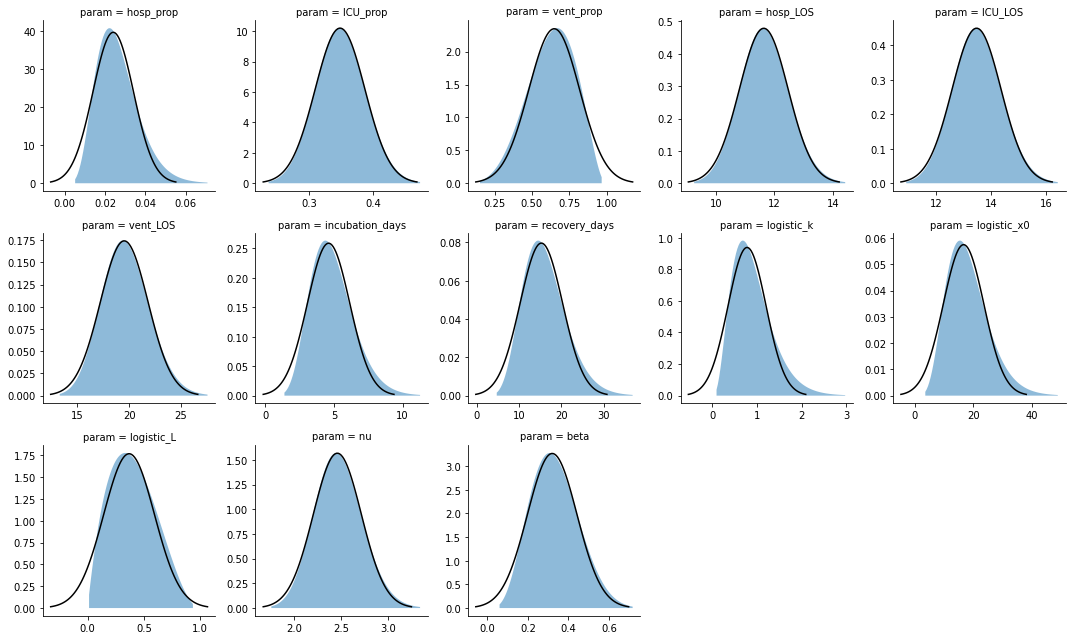

,val
hosp_prop,0.024(10)
ICU_prop,0.349(39)
vent_prop,0.65(17)
hosp_LOS,11.64(83)
ICU_LOS,13.47(89)
vent_LOS,19.5(2.3)
incubation_days,4.6(1.5)
recovery_days,15.3(5.0)
logistic_k,0.78(43)
logistic_x0,16.7(6.9)


In [6]:
g = FacetGrid(
    PRIOR_DF.query("distribution != 'constant'"),
    col="param",
    col_wrap=5,
    sharex=False,
    sharey=False,
)
g.map_dataframe(plot_prior_fit)
show_plot(g)
DataFrame(data=PRIORS, index=["val"]).T

## Fit posteriors

Next, posterior distributions are fitted using normal distributions as well.

The line below which reads in json may take a while. Maybe exporting to `HDF5` might be faster.

In [7]:
POSTERIOR_DF = read_json(
    path.join(OUTPUT, "output", "chains.json.bz2"), orient="records", lines=True
)
drop_cols = [
    col for col in POSTERIOR_DF.columns if col not in PRIORS and col != "offset"
]
POSTERIOR_DF = POSTERIOR_DF.drop(columns=drop_cols)

The below fit removes outliers to stabilize the fit

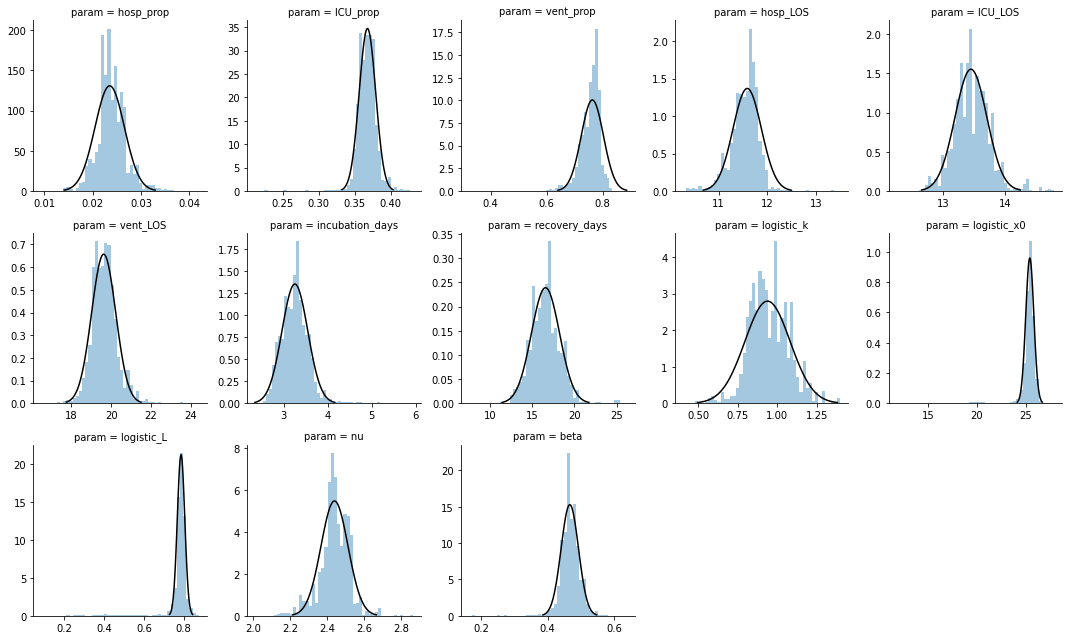

,val
hosp_prop,0.0235(30)
ICU_prop,0.368(11)
vent_prop,0.764(40)
hosp_LOS,11.59(29)
ICU_LOS,13.45(26)
vent_LOS,19.62(61)
incubation_days,3.25(29)
recovery_days,16.6(1.7)
logistic_k,0.94(14)
logistic_x0,25.41(42)


In [8]:
keys = PRIORS.keys()
POSTERIORS = avg_data(POSTERIOR_DF.T.loc[keys].T.values, median=True, spread=True)
POSTERIORS = {key: val for key, val in zip(keys, POSTERIORS)}

stacked = (
    POSTERIOR_DF.T.loc[PRIORS.keys()]
    .T.stack()
    .reset_index()
    .drop(columns=["level_0"])
    .rename(columns={"level_1": "param", 0: "x"})
)
g = FacetGrid(stacked, col="param", col_wrap=5, sharex=False, sharey=False,)

plot_dist = lambda **kwargs: distplot(
    a=kwargs["data"].x.values, kde=False, hist_kws={"density": True}
)

g.map_dataframe(plot_dist)

for ax, gv in zip(g.axes, POSTERIORS.values()):
    plot_gv_dist(gv, ax=ax, color="black")

show_plot(g)
DataFrame(data=[POSTERIORS], index=["val"]).T

# Propagate normal posteriors to SEIR and compare to original prediction

This section takes the fitted posterior distributions as input and propagates the parameter uncertainties through the SEIR model.

In [9]:
FORECAST_DF = read_csv(
    path.join(OUTPUT, "output", "forecast.csv"), parse_dates=["date"]
).set_index("date")

Below, the model is initialized.
To eventually run the simulation, the following parameters must be provided

In [10]:
seir = SEIRModel()
print(seir.model_parameters)
print(seir.optional_parameters)

['dates', 'initial_susceptible', 'initial_exposed', 'initial_infected', 'inital_recovered', 'beta', 'gamma', 'alpha']
['recovery_days', 'inital_doubling_time', 'incubation_days', 'initial_hospitalized', 'market_share', 'hospitalization_probability', 'hospital_length_of_stay']


The `model_parameters` must be provided before running a simulation.
The `optional_parameters` are pre and post-processing parameters which simplify the interface.
For example, if you specify `recovery_days`, this is used to compute `gamma`.

On the other hand, `hospitalization_probability` and `market_share` will add hospitalization information to the simulation in the post-processing.

In [11]:
total_infections = (
    META_PARS["n_hosp"] / META_PARS["mkt_share"] / POSTERIORS["hosp_prop"]
)

## Fixed paramters (no distributions)
XX = {
    "dates": FORECAST_DF.index,
    "market_share": META_PARS["mkt_share"],
    "initial_susceptible": META_PARS["region_pop"],
    "initial_infected": 0,
    "initial_recovered": 0,
    "initial_hospitalized": META_PARS["n_hosp"] / META_PARS["mkt_share"],
}
## Variable parameters (distributions)
PP = {
    "initial_exposed": total_infections,
    "incubation_days": POSTERIORS["incubation_days"],
    "beta": POSTERIORS["beta"],
    "recovery_days": POSTERIORS["recovery_days"],
    "nu": POSTERIORS["nu"],
    "hospitalization_probability": POSTERIORS["hosp_prop"],
    "hospital_length_of_stay": POSTERIORS["hosp_LOS"],
}

It is also possible to make parameters time-dependent. This is done by providing a `update_parameters` method. The arguments of this method are the simulation date and initial parameters (combined `XX` and `PP`). This method should return the updated parameters.
In the below example, a social distancing measure is implemented using a logistic function.

In [12]:
def update_parameters(ddate, **kwargs):
    xx = (ddate - kwargs["dates"][0]).days
    ppars = kwargs.copy()
    ppars["beta"] = kwargs["beta"] * one_minus_logistic_fcn(
        xx, L=kwargs["L"], k=kwargs["k"], x0=kwargs["x0"],
    )
    return ppars


OFFSET = POSTERIOR_DF.offset.mean()

PP["L"] = POSTERIORS["logistic_L"]
PP["x0"] = POSTERIORS["logistic_x0"] + OFFSET
PP["k"] = POSTERIORS["logistic_k"]

seir.update_parameters = update_parameters

In [13]:
%%timeit
seir.propagate_uncertainties(XX, PP)

20.4 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
FORCAST_DF_NORMAL = seir.propagate_uncertainties(XX, PP)

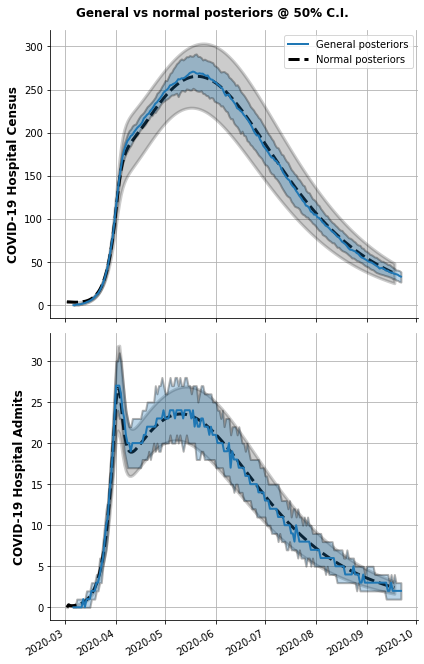

In [15]:
fig, axs = subplots(ncols=1, nrows=2, figsize=(6, 9))

gv_kws = dict(color="black", zorder=10, lw=3, z_factor=0.674)
gv_line_kws = {"ls": "--", "label": "Normal posteriors"}
gv_fill_kws = {"alpha": 0.2}

fill_kws = {"alpha": 0.3, "edgecolor": "k", "lw": 2}
line_kws = {"ls": "-", "label": "General posteriors", "lw": 2}

t_range_shifted = FORECAST_DF.index - timedelta(days=OFFSET)

# Census
ax = axs[0]
ax.set_ylabel(f"COVID-19 Hospital Census", fontsize=12, fontweight="bold")
ax.grid(True)

## General posteriors
plot_band(
    x=FORECAST_DF.index,
    y1=FORECAST_DF["Hospitalized Census 25%"],
    ym=FORECAST_DF["Hospitalized Census Median"],
    y2=FORECAST_DF["Hospitalized Census 75%"],
    fill_kws=fill_kws,
    line_kws=line_kws,
    ax=ax,
    zorder=20,
)
## Normal posteriors
plot_gvar(
    x=t_range_shifted,
    y=FORCAST_DF_NORMAL["hospital_census"].values,
    ax=ax,
    **gv_kws,
    line_kws=gv_line_kws,
    fill_kws=gv_fill_kws,
)

ax.legend(bbox_to_anchor=(1.0, 1.0))


# Admits
ax = axs[1]
ax.set_ylabel(f"COVID-19 Hospital Admits", fontsize=12, fontweight="bold")
ax.grid(True)

## General posteriors
plot_band(
    x=FORECAST_DF.index,
    y1=FORECAST_DF["Hospitalized Admits 25%"],
    ym=FORECAST_DF["Hospitalized Admits Median"],
    y2=FORECAST_DF["Hospitalized Admits 75%"],
    fill_kws=fill_kws,
    line_kws=line_kws,
    ax=ax,
    zorder=20,
)

## Normal posteriors
plot_gvar(
    x=t_range_shifted,
    y=FORCAST_DF_NORMAL["hospital_admits"].values,
    ax=ax,
    **gv_kws,
    line_kws=gv_line_kws,
    fill_kws=gv_fill_kws,
)


fig.suptitle(
    "General vs normal posteriors @ 50% C.I.", y=1.02, fontsize=12, fontweight="bold"
)
fig.autofmt_xdate()
fig.tight_layout()

despine()
show_plot(fig)

Note that the size of the census uncertainties differs by a few standard deviations while the mean agrees. This is interesting as they are computed using admission data (which agrees) and use the same function (see `bayes_chime/normal/models/sir.py` line 70). 

## Compute normal posteriors given normal priors

In this section, original priors are approximated by normal distributions and `lsqfit` is used to compute posteriors.

To account for the offset, the data is extended with zeros before the first date.

In [16]:
extended_range = date_range(
    DATA_DF.index[0] - timedelta(int(OFFSET)), freq="D", periods=OFFSET
)
tmp = DataFrame(index=extended_range, columns=DATA_DF.columns).fillna(0)
extended_data = concat([tmp, DATA_DF])
extended_data.head()

,hosp,vent,mort
2020-03-02,0,0,0
2020-03-03,0,0,0
2020-03-04,0,0,0
2020-03-05,0,0,0
2020-03-06,1,0,0


This is the same as above with the difference that now the priors are used instead of the posteriors and the date range is set by the data.

In [17]:
total_infections = META_PARS["n_hosp"] / META_PARS["mkt_share"] / PRIORS["hosp_prop"]

## Fixed paramters (no distributions)
xx = {
    "dates": extended_data.index,
    "market_share": META_PARS["mkt_share"],
    "initial_susceptible": META_PARS["region_pop"],
    "initial_infected": 0,
    "initial_recovered": 0,
    "initial_hospitalized": META_PARS["n_hosp"] / META_PARS["mkt_share"],
}
## Variable parameters (distributions)
pp = {
    "initial_exposed": total_infections,
    "incubation_days": PRIORS["incubation_days"],
    "beta": PRIORS["beta"],
    "recovery_days": PRIORS["recovery_days"],
    "nu": PRIORS["nu"],
    "hospitalization_probability": PRIORS["hosp_prop"],
    "hospital_length_of_stay": PRIORS["hosp_LOS"],
}

In [18]:
pp["L"] = PRIORS["logistic_L"]
pp["x0"] = PRIORS["logistic_x0"] + OFFSET
pp["k"] = PRIORS["logistic_k"]

One has to specify the time range and data (columns) to fit. For now, this only fits the hospitalized census data.

In [19]:
seir.fit_start_date = "2020-03-06"
seir.fit_columns = "hospital_census"
seir.debug = False

Furthermore, one needs to know the uncertainty of the data.
Since I have no experience with how reliable this data is (one also must account for temporal fluctuations), I estimate the uncertainty to be 10% of the mean plus an additional 10 patients to not emphasize early points too much.

In [20]:
yy = gvar(DATA_DF.hosp.values, DATA_DF.hosp.values * 0.1 + 10)

The below method checks if the function call does not raise any problems (e.g., too few prior parameters or data is of the wrong shape)

In [21]:
seir.check_call(xx, yy, pp)

Checks passed


This runs the fit and computes posteriors (stored in `fit.p`)

In [22]:
fit = nonlinear_fit(data=(xx, yy), prior=pp, fcn=seir.fit_fcn, debug=False)

In [23]:
%%timeit
nonlinear_fit(data=(xx, yy), prior=pp, fcn=seir.fit_fcn, debug=False)

1.89 s ± 223 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


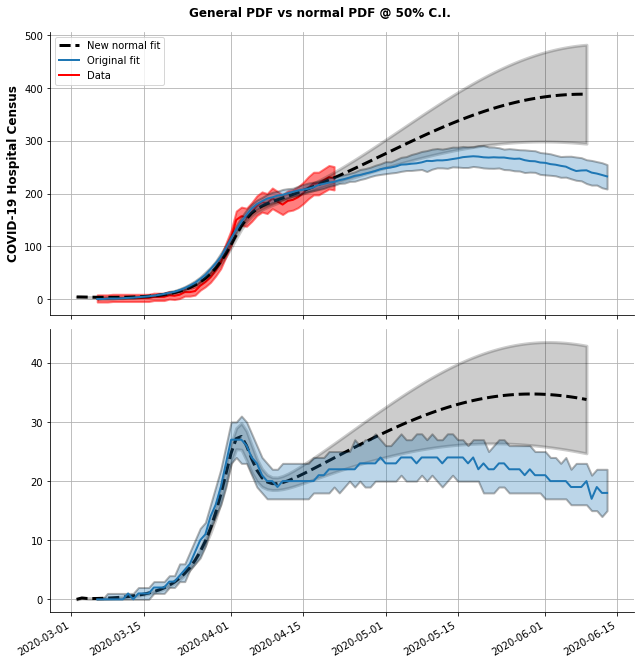

In [24]:
x_prediction = xx.copy()
tf = FORECAST_DF.iloc[:100]
x_prediction["dates"] = tf.index
df = seir.propagate_uncertainties(x_prediction, fit.p)
df.index -= timedelta(days=OFFSET)

fig, axs = subplots(ncols=1, nrows=2, figsize=(9, 9), sharex=False)

gv_kws = dict(color="black", zorder=10, lw=3, z_factor=0.674)
gv_line_kws = {"ls": "--", "label": "New normal fit"}
gv_fill_kws = {"alpha": 0.2}

fill_kws = {"alpha": 0.3, "edgecolor": "k", "lw": 2}
line_kws = {"ls": "-", "label": "Original fit", "lw": 2}


# Census
ax = axs[0]
ax.set_ylabel(f"COVID-19 Hospital Census", fontsize=12, fontweight="bold")
ax.grid(True)

## Fit
plot_gvar(
    x=df.index,
    y=df["hospital_census"].values,
    ax=ax,
    **gv_kws,
    line_kws=gv_line_kws,
    fill_kws=gv_fill_kws,
)

## Original
ax.set_ylabel(f"COVID-19 Hospital Census", fontsize=12, fontweight="bold")
plot_band(
    x=tf.index,
    y1=tf["Hospitalized Census 25%"],
    ym=tf["Hospitalized Census Median"],
    y2=tf["Hospitalized Census 75%"],
    fill_kws=fill_kws,
    line_kws=line_kws,
    ax=ax,
    zorder=20,
)

## Data
plot_gvar(
    x=DATA_DF.index,
    y=yy,
    ax=ax,
    z_factor=0.674,
    color="red",
    line_kws={**line_kws, "label": "Data"},
    fill_kws={**fill_kws, "alpha": 0.5, "zorder": 5},
)
ax.legend(loc="upper left")


# Admits
ax = axs[1]
ax.grid(True)

## Prediction
plot_gvar(
    x=df.index,
    y=df["hospital_admits"].values,
    ax=ax,
    **gv_kws,
    line_kws=gv_line_kws,
    fill_kws=gv_fill_kws,
)
ax.grid(True)


## Original
plot_band(
    x=tf.index,
    y1=tf["Hospitalized Admits 25%"],
    ym=tf["Hospitalized Admits Median"],
    y2=tf["Hospitalized Admits 75%"],
    fill_kws=fill_kws,
    line_kws=line_kws,
    ax=ax,
    zorder=20,
)


fig.suptitle(
    "General PDF vs normal PDF @ 50% C.I.", y=1.02, fontsize=12, fontweight="bold"
)
fig.autofmt_xdate()
fig.tight_layout()

despine()
show_plot(fig)

In [25]:
print(fit)

# Convert names back to original
name_map = {
    "L": "logistic_L",
    "x0": "logistic_x0",
    "k": "logistic_k",
    "hospitalization_probability": "hosp_prop",
    "hospital_length_of_stay": "hosp_LOS",
}

new_posterior = {name_map.get(key, key): val for key, val in fit.p.items()}
new_posterior["logistic_x0"] -= OFFSET
new_prior = {name_map.get(key, key): val for key, val in pp.items()}

# Create comparison frame
comparison = DataFrame(
    [new_prior, new_posterior, POSTERIORS],
    index=["Priors", "PDF from normal approx", "PDF from general dists",],
).T.dropna()

# Compute difference in standard deviations
comparison["diff"] = (
    comparison["PDF from normal approx"] - comparison["PDF from general dists"]
)
comparison["z"] = comparison["diff"].apply(lambda x: abs(x.mean) / x.sdev)

# Present
comparison.sort_values("z", ascending=False)

Least Square Fit:
  chi2/dof [dof] = 0.38 [47]    Q = 1    logGBF = -194.77

Parameters:
            initial_exposed       69 (48)     [   160 (67) ]  *
            incubation_days     3.0 (1.1)     [  4.6 (1.5) ]  *
                       beta    0.478 (89)     [  0.32 (12) ]  *
              recovery_days    17.1 (4.9)     [ 15.3 (5.0) ]  
                         nu     2.46 (25)     [  2.46 (25) ]  
hospitalization_probability   0.0378 (71)     [ 0.024 (10) ]  *
    hospital_length_of_stay    11.49 (83)     [ 11.64 (83) ]  
                          L    0.793 (47)     [  0.37 (23) ]  *
                         x0    29.7 (1.1)     [ 20.7 (6.9) ]  *
                          k     1.02 (41)     [  0.78 (43) ]  

Settings:
  svdcut/n = 1e-12/1    tol = (1e-08,1e-10,1e-10*)    (itns/time = 117/1.8)
  fitter = scipy_least_squares    method = trf



,Priors,PDF from normal approx,PDF from general dists,diff,z
hosp_prop,0.024(10),0.0378(71),0.0235(30),0.0142(78),1.830691
logistic_x0,20.7(6.9),25.7(1.1),25.41(42),0.3(1.1),0.257920
incubation_days,4.6(1.5),3.0(1.1),3.25(29),-0.2(1.1),0.201248
logistic_k,0.78(43),1.02(41),0.94(14),0.08(43),0.188333
beta,0.32(12),0.478(89),0.467(26),0.011(93),0.120969
logistic_L,0.37(23),0.793(47),0.787(19),0.005(50),0.108672
hosp_LOS,11.64(83),11.49(83),11.59(29),-0.09(88),0.107157
recovery_days,15.3(5.0),17.1(4.9),16.6(1.7),0.5(5.2),0.105776
nu,2.46(25),2.46(25),2.440(73),0.02(26),0.069792


Besides the `hosp_prop`, fitted parameters seem to agree. This might be related to optimization criteria or the estimated data uncertainty which I have not analyzed in detail.